# Three states MIS algorithm

After simulating a guess algorithm for a 2 level rydberg atom system trying to solve MIS with adiabatic quantum computing

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
# The library for quantum adiabatic simulations.
from qutip import * 
from scipy import *
# The library used for the graph representation.  
import networkx as nx
from guess_algorithm_helper import *
from random import randint
import ipynb.fs.defs.guess_algorithm as algo

and follow up complexity testing compared to classical algorithms

In [98]:
import ipynb.fs.defs.guess_algorithm_tester as tester

We got mixed results. When the guess was close to the expected results, the guess did amazing and we saw huge improvement. 
However, when the guess wasn't as close, as expected the normal algorithm which starts with a ground state for all atoms did better. 

Hence, we want to implement Luby's algorithm, which uses degree based guesses and is one of the best MIS solvers in classical algorithms. Meaning that our goal is implementing something like:
$$|\psi_0 \rangle=\sqrt{\frac{1}{dv}} |r \rangle + \sqrt{1-\frac{1}{dv}} |g \rangle$$

Which would be great, but is also impossible. That is because this will have a probability of neighboring vertexs being in Rydberg states.
To solve that, we will attempt to create a three level system. In the beginning we will only have states at $|0 \rangle$ and $|1 \rangle$. where $|1 \rangle$ is choosing the vertex and $|0 \rangle$ is not choosing the vertex. Meaning that 
$$|\psi_0 \rangle=\sqrt{\frac{1}{dv}} |1 \rangle + \sqrt{1-\frac{1}{dv}} |0 \rangle$$
 
Just like we wanted. And the starting hamiltonain will also reflect that. After some time, using some rabi frequency $\Omega(t)$, we will move as many atoms as possible from $|1 \rangle$ to $|r \rangle$. Which can be looked as as the original 2 states algorithm with $|1 \rangle$ being the ground. Finally, qbits that are in $|0 \rangle$ that can be moved to $|R \rangle$ are moved using the same alogirthm but with $|0 \rangle$ as the base state instead of $|1 \rangle$.

Since at the start the rydberg state probability is 0, all initial states will be viable ground states without any need for $H_0$ to be implemented at the start of the run.Hence we get:

$$\begin{cases}
H_0 = \sum_{n=1}^NI - \sigma_{x_{1,r}} ^n \\
H_1 = \sum_{n=1}^NI - \sigma_{x_{0,r}} ^n \\
H_p = -\Delta n_v \\
H_{int} = \sum_{v<w}V/x^6(|\vec{x}_v-\vec{x}_w|)n_vn_w
\end{cases}
$$

With 
$$\sigma_{x_{1,r}} = \begin{pmatrix}
0 & 0 & 0 \\
0 & 0 & 1 \\
0 & 1 & 0
\end{pmatrix} \quad, \quad \sigma_{x_{0,r}} = \begin{pmatrix}
0 & 0 & 1 \\
0 & 0 & 0 \\
0 & 1 & 0
\end{pmatrix}$$

Using that we can build a full hamiltonian:
$$H_{tot} = H_0 \Omega(t)+ H_1\Omega(t+\epsilon) + H_p\Delta(t) + H_{int}$$

---

## Chain Graph Example with 5 Vertices

As an example, assume we have a **chain graph with 5 vertices**:  
$$
\boxed{O} \longrightarrow \boxed{O} \longrightarrow \boxed{O} \longrightarrow \boxed{O} \longrightarrow \boxed{O}
$$

We start with the following initial state:

- **Green** represents an initial guess of $ |1 \rangle $.
- **Orange** represents an initial guess of $ \frac{1}{\sqrt{2}}(|0 \rangle + |1 \rangle) $.

The initial state of the graph is:

$$
\begin{aligned}
&\colorbox{green}{\textbf{1}} \longrightarrow 
\colorbox{orange}{\textbf{1,0}} \longrightarrow 
\colorbox{orange}{\textbf{1,0}} \longrightarrow 
\colorbox{orange}{\textbf{1,0}} \longrightarrow 
\colorbox{green}{\textbf{1}}
\end{aligned}
$$

---

## State Evolution: First Example

In the first example, consider the following evolution of states:

1. **Initial State**:  
   $$
   \begin{aligned}
   &\colorbox{green}{\textbf{1}} \longrightarrow 
   \colorbox{red}{\textbf{0}} \longrightarrow 
   \colorbox{red}{\textbf{0}} \longrightarrow 
   \colorbox{red}{\textbf{0}} \longrightarrow 
   \colorbox{green}{\textbf{1}}
   \end{aligned}
   $$

2. **After Activating \( H_0 \)**:  
   $$
   \begin{aligned}
   &\colorbox{blue}{\textbf{R}} \longrightarrow 
   \colorbox{red}{\textbf{0}} \longrightarrow 
   \colorbox{red}{\textbf{0}} \longrightarrow 
   \colorbox{red}{\textbf{0}} \longrightarrow 
   \colorbox{blue}{\textbf{R}}
   \end{aligned}
   $$

3. **After Activating \( H_1 \)**:  
   $$
   \begin{aligned}
   &\colorbox{blue}{\textbf{R}} \longrightarrow 
   \colorbox{red}{\textbf{0}} \longrightarrow 
   \colorbox{blue}{\textbf{R}} \longrightarrow 
   \colorbox{red}{\textbf{0}} \longrightarrow 
   \colorbox{blue}{\textbf{R}}
   \end{aligned}
   $$

   Which is the correct MIS.

---

## State Evolution: Second Example

We now look at a more complicated possibility starting from the same initial state:

### Initial State  
$$
\begin{aligned}
&\colorbox{green}{\textbf{1}} \longrightarrow 
\colorbox{orange}{\textbf{1,0}} \longrightarrow 
\colorbox{orange}{\textbf{1,0}} \longrightarrow 
\colorbox{orange}{\textbf{1,0}} \longrightarrow 
\colorbox{green}{\textbf{1}}
\end{aligned}
$$

### Intermediate State  
At one point, the state can evolve into:  
$$
\begin{aligned}
&\colorbox{green}{\textbf{1}} \longrightarrow 
\colorbox{green}{\textbf{1}} \longrightarrow 
\colorbox{red}{\textbf{0}} \longrightarrow 
\colorbox{red}{\textbf{0}} \longrightarrow 
\colorbox{green}{\textbf{1}}
\end{aligned}
$$

### After Activating $ H_0 $  
This results in a superposition of states:  
$$
\begin{aligned}
&\colorbox{orange}{\textbf{1,R}} \longrightarrow 
\colorbox{orange}{\textbf{1,R}} \longrightarrow 
\colorbox{red}{\textbf{0}} \longrightarrow 
\colorbox{red}{\textbf{0}} \longrightarrow 
\colorbox{blue}{\textbf{R}}
\end{aligned}
$$

One of the possible states in this superposition is:  
$$
\begin{aligned}
&\colorbox{green}{\textbf{1}} \longrightarrow 
\colorbox{blue}{\textbf{R}} \longrightarrow 
\colorbox{red}{\textbf{0}} \longrightarrow 
\colorbox{red}{\textbf{0}} \longrightarrow 
\colorbox{blue}{\textbf{R}}
\end{aligned}
$$



Remember the total Hamiltonian is:  
$$
H_{tot} = H_0 \Omega(t)+ H_1\Omega(t+\epsilon) + H_p\Delta(t) + H_{int}
$$


Hence if $ \epsilon $ is chosen such that $ H_1 $ and $ H_0 $ are active at the same time, the resulting state is:  
$$
\begin{aligned}
&\colorbox{blue}{\textbf{R}} \longrightarrow 
\colorbox{red}{\textbf{0}} \longrightarrow 
\colorbox{blue}{\textbf{R}} \longrightarrow 
\colorbox{red}{\textbf{0}} \longrightarrow 
\colorbox{blue}{\textbf{R}}
\end{aligned}
$$

  
However, this approach comes at a high cost because the total amplitude increases.

### Large $ \epsilon $ Solution  
If $ \epsilon $ is large enough, we obtain a different solution:  
$$
\begin{aligned}
&\colorbox{green}{\textbf{1}} \longrightarrow 
\colorbox{blue}{\textbf{R}} \longrightarrow 
\colorbox{red}{\textbf{0}} \longrightarrow 
\colorbox{red}{\textbf{0}} \longrightarrow 
\colorbox{blue}{\textbf{R}}
\end{aligned}
$$

This solution is valid for the **Maximal Independent Set (MIS)**, but it is not the correct solution for the **Maximum Independent Set**.

<>:30: SyntaxWarning: invalid escape sequence '\O'
<>:30: SyntaxWarning: invalid escape sequence '\O'
/var/folders/h_/vy4w9dxn1tj1hk2f15n3qn3m0000gn/T/ipykernel_10465/3521323477.py:30: SyntaxWarning: invalid escape sequence '\O'
  plt.title('Time Evolution of $\Omega_1(t)$, $\Omega_2(t)$, and $\Delta(t)$')


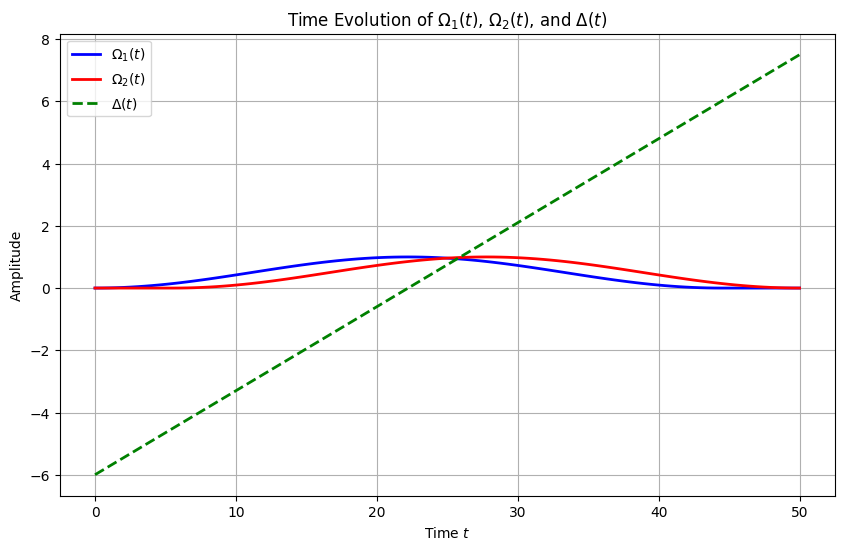

In [99]:
from qutip import qeye, basis, Qobj, tensor, sigmaz

########################
# Define our functions #
########################

import matplotlib.pyplot as plt

def timeEvoPlot(taulist, Omega_1_func, Omega_2_func, Delta_func):
    # Create a figure for plotting
    plt.figure(figsize=(10, 6))
    
    # Calculate Omega_1, Omega_2, and Delta for each time value in taulist
    Omega_1_values = [Omega_1_func(t) for t in taulist]
    Omega_2_values = [Omega_2_func(t) for t in taulist]
    Delta_values = [Delta_func(t) for t in taulist]
    
    # Plot Omega_1(t)
    plt.plot(taulist, Omega_1_values, label=r'$\Omega_1(t)$', color='blue', linewidth=2)
    
    # Plot Omega_2(t)
    plt.plot(taulist, Omega_2_values, label=r'$\Omega_2(t)$', color='red', linewidth=2)
    
    # Plot Delta(t)
    plt.plot(taulist, Delta_values, label=r'$\Delta(t)$', color='green', linewidth=2, linestyle='--')

    # Add labels, title, and legend
    plt.xlabel('Time $t$')
    plt.ylabel('Amplitude')
    plt.title('Time Evolution of $\Omega_1(t)$, $\Omega_2(t)$, and $\Delta(t)$')
    plt.legend(loc='best')
    plt.grid(True)
    
    # Show the plot
    plt.show()
    
init_params = algo.initialize_system_parameters(tau_max=50,vertex_placement = 0.8)
EPSILON = init_params["TAU_MAX"]/9
def Omega_1(t):
    if t>init_params["TAU_MAX"]-EPSILON:
            return 0
    else: 
        return init_params["OMEGA_0"] * np.sin(np.pi * t / (init_params["TAU_MAX"]-EPSILON)) ** 2

def Omega_2(t):
    if t<EPSILON:
            return 0
    else: 
        return init_params["OMEGA_0"] * np.sin(np.pi * (t-EPSILON) / (init_params["TAU_MAX"]-EPSILON)) ** 2
def Delta_1(t):
    return init_params["DELTA_0"] * (2 * t / (init_params["TAU_MAX"]-EPSILON) - 1)
timeEvoPlot(init_params["taulist"], Omega_1,Omega_2, Delta_1)

In [100]:

class LubyHamiltonian(algo.BaseHamiltonian):
    def __init__(self, params, graph_instance):
        """
        Initializes the Hamiltonian base class with system parameters and graph information.

        Args:
        params (dict): Dictionary of system parameters.
        graph_instance (Graph): Instance of a graph representing the system.
        """
        self.params = params
        self.graph = graph_instance.graph
        self.N = len(self.graph.nodes)
        self.sx_list_0,self.sx_list_1, self.sz_list, self.one_list, self.I_N = self.generate_operators()
    def generate_operators(self):
        """
        Generates useful quantum operators for a system of N states, including a custom sigma_x operator.

        Parameters:
        N (int): The number of operators to generate.
        num_states (int): The dimension of the Hilbert space for each state (e.g., 2 for qubits, 3 for qutrits).

        Returns:
        tuple: A tuple containing lists of tensor products of generalized operators.
            (sx_list, sz_list, one_list, I_N)
        """
        # Identity operator for the specified number of states
        si = qeye(3)


        # Custom σ_x operator for states |0> and |2>, converted to Qobj
        sx_custom_0 = Qobj([[0, 0, 1],
                        [0, 0, 1],
                        [0, 1, 0]])


        # Custom σ_x operator for states |1> and |2>, converted to Qobj
        sx_custom_1 = Qobj([[0, 0, 0],
                        [0, 0, 1],
                        [0, 1, 0]])

        # Initialize empty lists for storing operators
        sx_list_1 = []
        sx_list_0 = []
        sz_list = []
        one_list = []

        # Identity tensor for N states
        I_N = tensor([si] * self.N)

        # Generate the operators
        for n in range(self.N):
            # Initialize a list of identities for the tensor product
            op_list = [si] * self.N

            op_list[n] = sx_custom_0
            sx_list_0.append(tensor(op_list))
            # Replace the n-th position with the custom sx operator
            op_list[n] = sx_custom_1
            sx_list_1.append(tensor(op_list))

            # Replace the n-th position with the sz operator
            # Define the 3x3 Pauli-Z matrix for a 3-level system
            sz_3 = np.diag([1, -1, 1])  # A diagonal matrix for the 3-level system
            sz = Qobj(sz_3)
            op_list[n] = sz
            sz_list.append(tensor(op_list))

            # Replace the n-th position with |1><1|
            one = basis(3, 2)  # |1><1| in higher dimensions
            op_list[n] = one * one.dag()
            one_list.append(tensor(op_list))
        return sx_list_0,sx_list_1, sz_list, one_list, I_N

    def create_hamiltonian(self):
        # Base class already calculates the interaction Hamiltonian (H_int)
        H_int = self.create_interaction_term()

        # Specific terms for this Hamiltonian
        CL_H1 = self.I_N - sum(self.sx_list_1)  # Example term for the Hamiltonian
        CL_H0 = self.I_N - sum(self.sx_list_0)  # 
        Hp = -sum(self.one_list)  # Example term for the Hamiltonian

        # Return the Hamiltonian in the required format
        return [[CL_H1, Omega_1],[2*CL_H0, Omega_2], [Hp, Delta_1], H_int]
    
    def initialize_state(self):
        guesses = [(np.sqrt(1/self.graph.degree[n]))*basis(3, 1) +  (np.sqrt(1-1/self.graph.degree[n]))*basis(3, 0) for n in range(self.N)]
        return qutip.tensor(guesses)



## Testing the algorithm

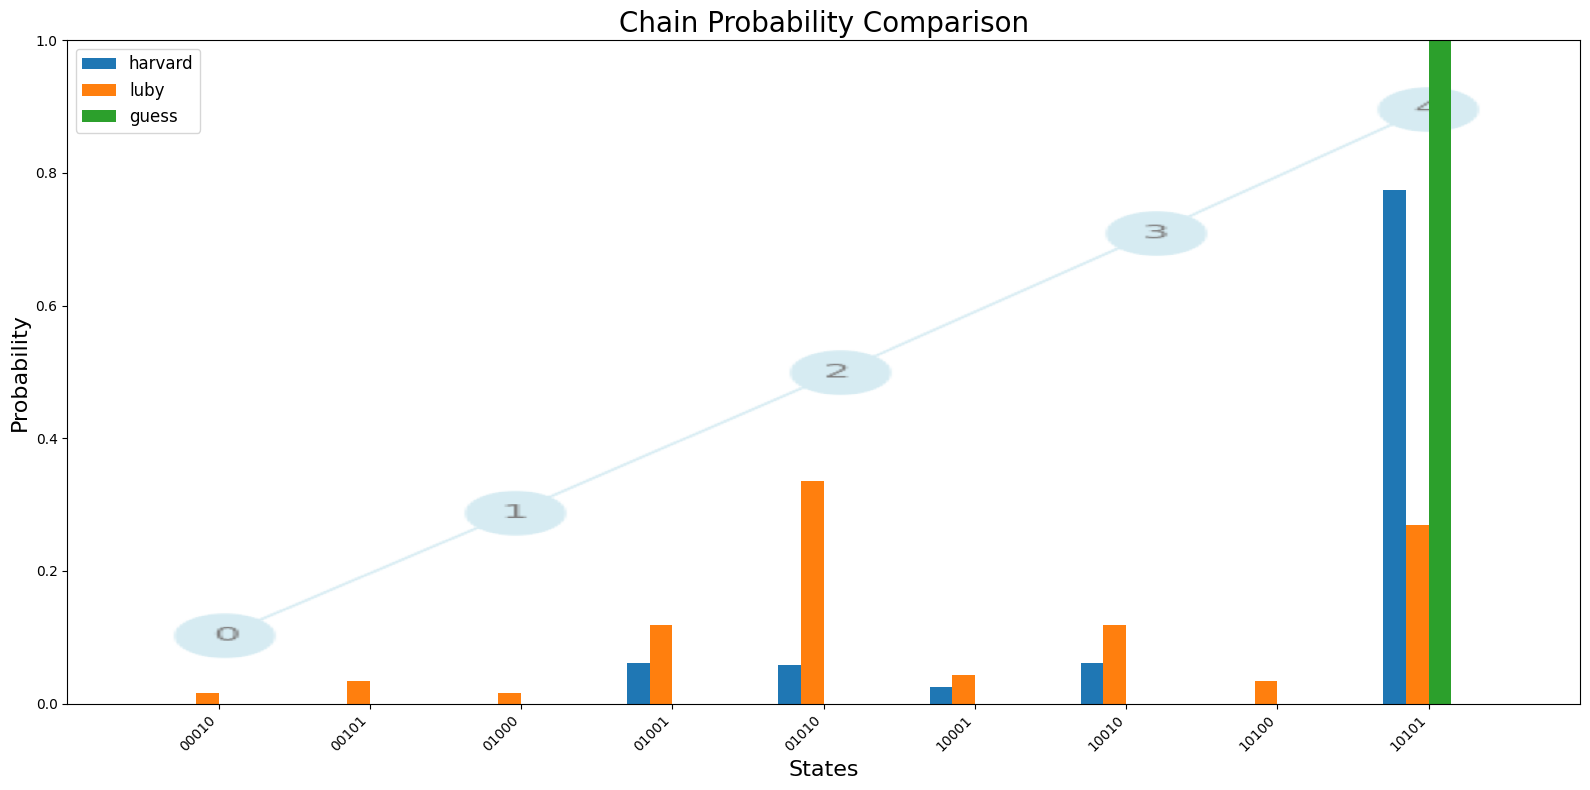

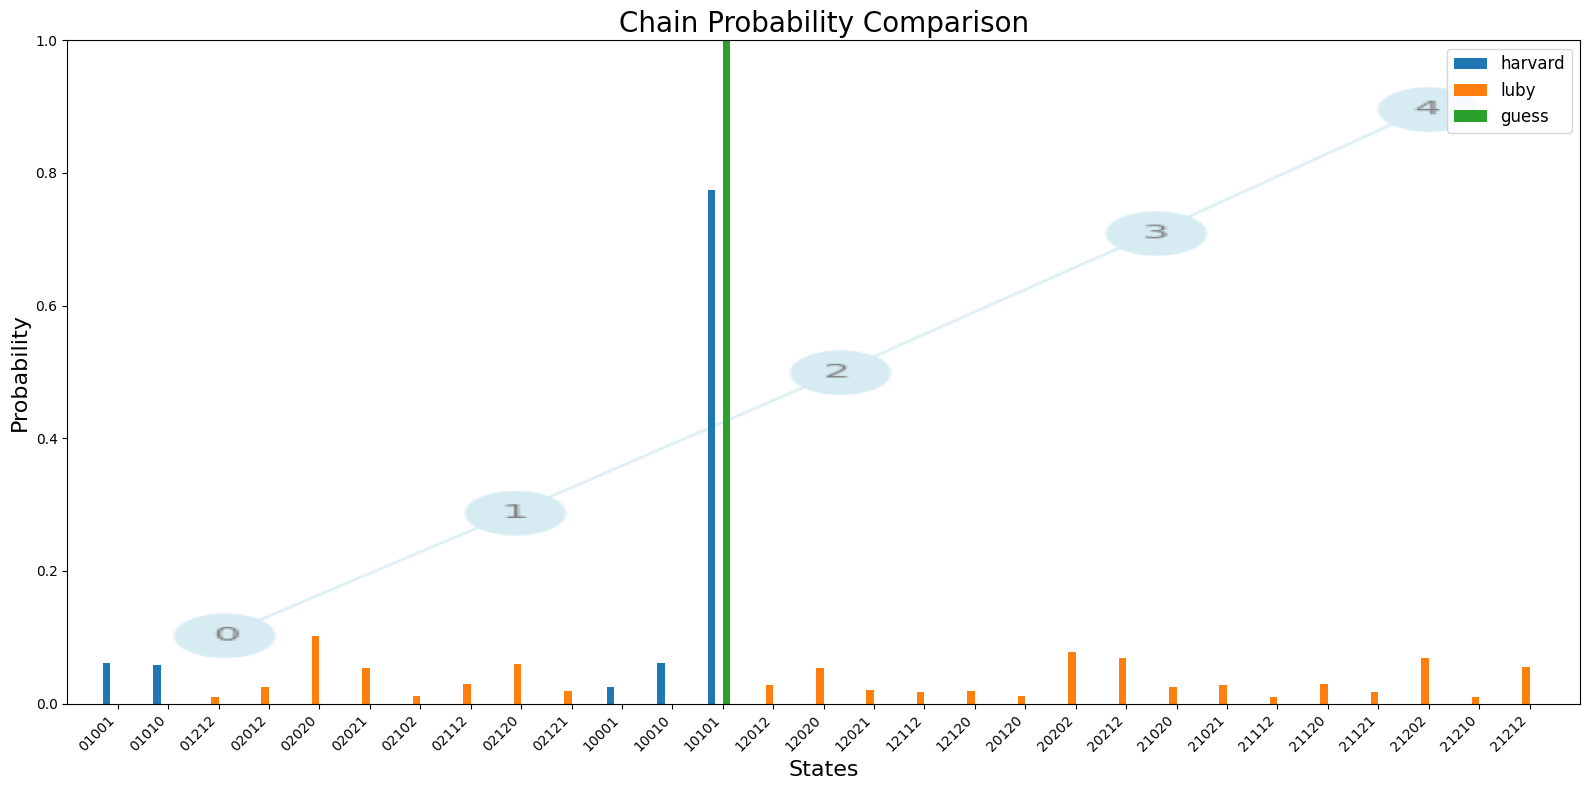

In [101]:
N = 5
init_params = algo.initialize_system_parameters(tau_max=10,vertex_placement = 0.8)
chain_graph = algo.ChainGraph(N)
chain_graph.create_graph()
# Initialize Hamiltonians
harvard_hamiltonian = algo.HarvardHamiltonian(init_params, chain_graph)
luby_hamiltonian = LubyHamiltonian(init_params, chain_graph)
guess_hamiltonian = algo.GuessHamiltonian(init_params, chain_graph,algo.default_guess_function)

# Solve each Hamiltonian
harvard_h_t, harvard_result = harvard_hamiltonian.solve()
luby_h_t, luby_result = luby_hamiltonian.solve()
guess_h_t, guess_result = guess_hamiltonian.solve()

# Consolidate results
# Consolidate results
hamiltonians_out = {
    "harvard": harvard_h_t,
    "luby": luby_h_t,
    "guess": guess_h_t,
}

results_out = {
    "harvard": harvard_result,
    "luby": luby_result,
    "guess": guess_result,
}

algo.plot_probabilities(results_out, N, graph_type="Chain", graph=chain_graph, threshold=0.01, merge_states_flag=True)
algo.plot_probabilities(results_out, N, graph_type="Chain", graph=chain_graph, threshold=0.01, merge_states_flag=False)

# splitting the algorithms 

For now, I can't seem to make it work. Hence we wil split the algorithm. First we will run the first part of the algorithm (meaning that we will use only $H_1$). Then we can use the result of it as a heuristic guess and run the guess algorithm we already created.   

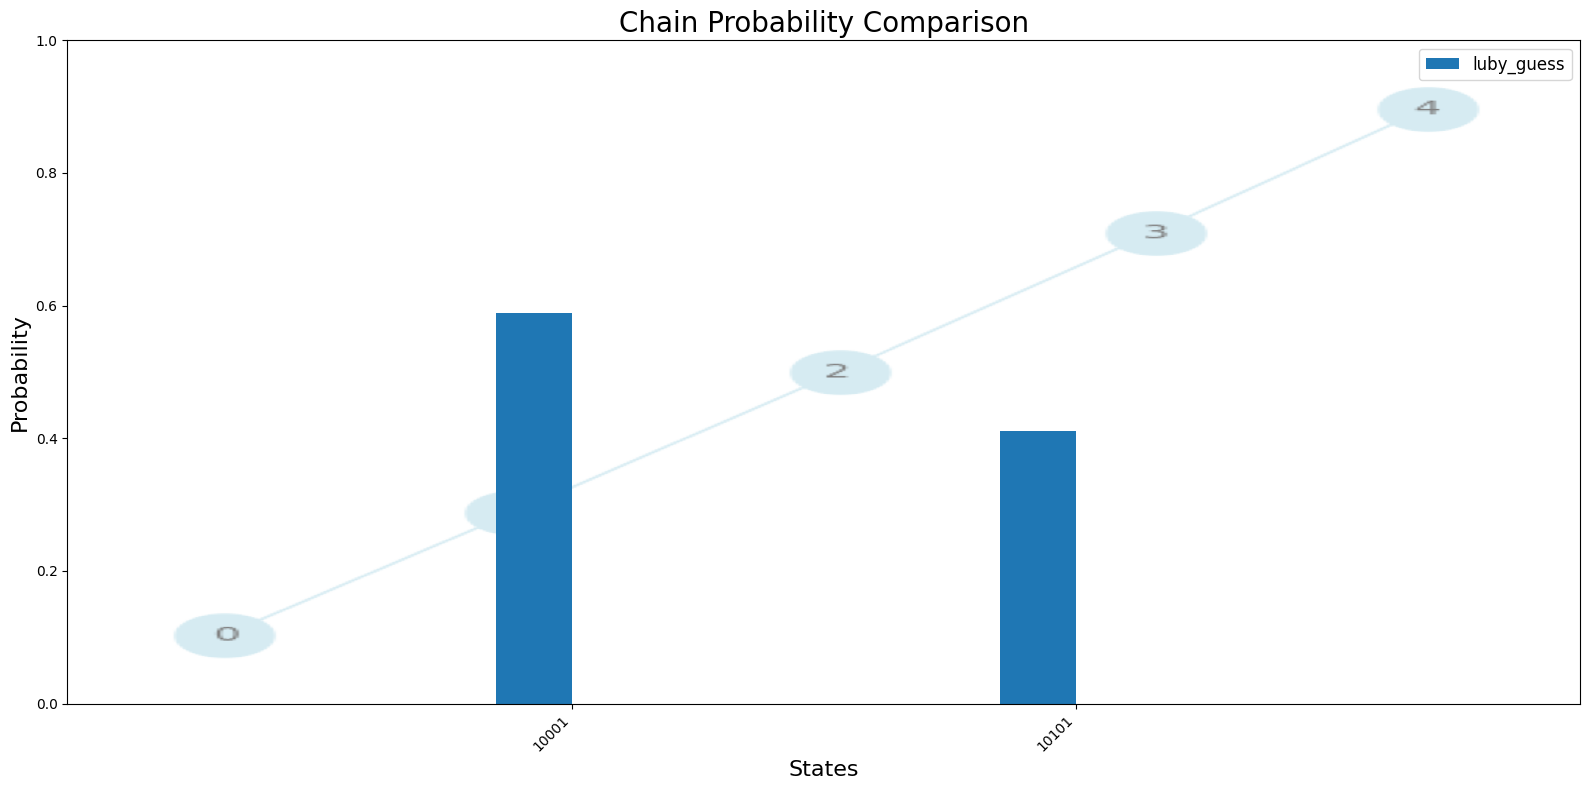

In [102]:
# init_params = algo.initialize_system_parameters(tau_max=20,vertex_placement = 0.8)
class LubyGuessHamiltonian(LubyHamiltonian):
    
    def create_hamiltonian(self):
        
        H_int = self.create_interaction_term()
        Hp = -sum(self.one_list)
        GU_H1,Hd = algo.huristic_guess(
            self.graph, self.sx_list_1, self.sz_list, self.I_N, self.params['DEGREE_MIN'], algo.default_guess_function, self.params['delta'])
        return [
            [self.params['DELTA_0'] * GU_H1, lambda t: 1 - t / self.params['TAU_MAX']],  # Time-dependent term for GU_H0
            [Hd, self.params['Omega']],  # Static term for Hd
            [self.params['DELTA_0'] * Hp, lambda t: t / self.params['TAU_MAX']],  # Time-dependent term for Hp
            H_int  # Interaction term
        ]
    
    def initialize_state(self):
        """
        Initialize the state using a heuristic function for guess creation.
        If the heuristic guess function evaluates to True, initialize with |2>.
        Otherwise, initialize a superposition of |1> and |0>.
        """
        guesses = [
            qutip.basis(3, 2) if algo.default_guess_function(self.graph, n, self.params['DEGREE_MIN']) else 
            (np.sqrt(1/self.graph.degree[n])) * qutip.basis(3, 1) +
            (np.sqrt(1 - 1/self.graph.degree[n])) * qutip.basis(3, 0) 
            for n in range(self.N)
        ]
        return qutip.tensor(guesses)


# Instantiate the guess Hamiltonian for Luby's Algorithm
luby_guess_hamiltonian = LubyGuessHamiltonian(init_params, chain_graph)
luby_guess_h_t, luby_guess_result = luby_guess_hamiltonian.solve()

hamiltonians_out = {
    
    "luby_guess": luby_guess_h_t,
}

results_out = {
    "luby_guess": luby_guess_result,
}


algo.plot_probabilities(
    results_out=results_out,
    N=5,
    graph_type="Chain",
    graph=chain_graph,
    threshold=0.01,
    merge_states_flag=True
)


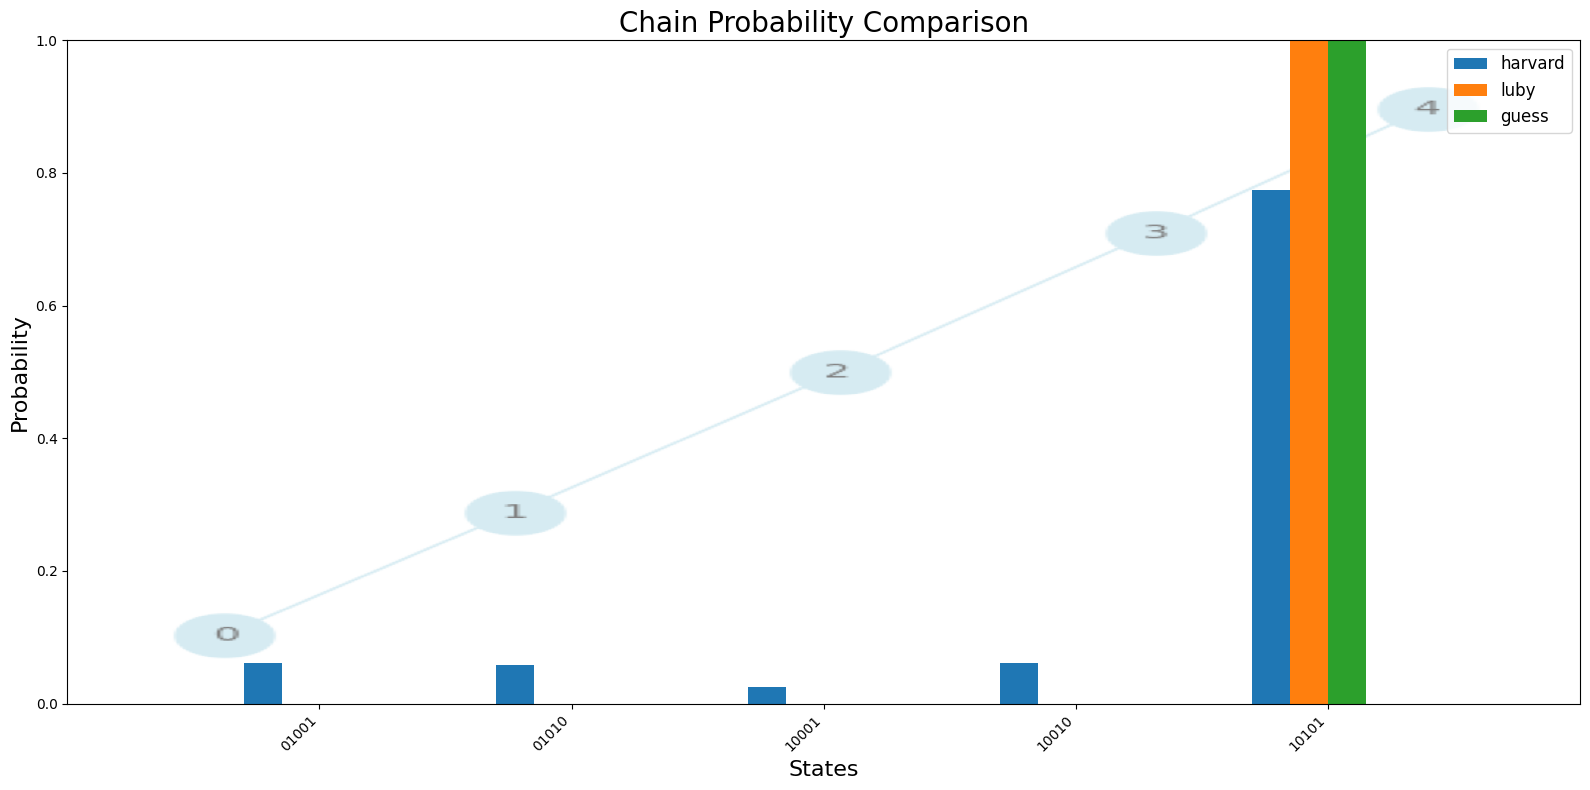

In [103]:
import random

# Step 1: Extract and Adjust Relevant States
def extract_adjusted_states(luby_guess_result, N, threshold=0.01):
    """
    Extract relevant states from the luby_guess_result and adjust them based on rules.
    - If it's (3, 2), transform it to (2, 1)
    - If it's (3, 1) or (3, 0), transform it to (2, 0)
    
    Parameters:
    - luby_guess_result: The result object from `luby_guess_hamiltonian.solve()`.
    - N: Number of nodes in the graph.
    - threshold: Minimum probability to consider a state relevant.

    Returns:
    - adjusted_states: List of adjusted states for each node.
    """
    probabilities = [np.abs(a_i[0])**2 for a_i in luby_guess_result.states[-1].full()]
    all_states = [''.join(map(str, combination)) for combination in product(range(3), repeat=N)]

    # Filter states based on threshold
    relevant_indices = np.where(np.array(probabilities) > threshold)[0]
    relevant_states = [all_states[idx] for idx in relevant_indices if idx < len(all_states)]

    # Adjust states based on the rules
    adjusted_states = []
    for state in relevant_states:
        adjusted_state = []
        for char in state:
            if char == '2':  # Map '2' -> '1'
                adjusted_state.append('1')
            elif char == '1' or char == '0':  # Map '1' or '0' -> '0'
                adjusted_state.append('0')
        adjusted_states.append(''.join(adjusted_state))
    
    return adjusted_states

# Step 2: Define the Luby Guess Function
def luby_guess_func(graph, node_index, degree_min, adjusted_state):
    """
    Generate the heuristic guess function based on the adjusted states.
    
    Parameters:
    - graph: The graph structure.
    - node_index: The current node index in the graph.
    - degree_min: The minimum degree parameter.
    - adjusted_states: The adjusted states list for each node.
    
    Returns:
    - True if the guess function evaluates to |2>, False otherwise.
    """
    # Map the adjusted state for the current node to |2> or other values

    adjusted_vertex_state = adjusted_state[node_index]
    return adjusted_vertex_state == '1'  # Use |1> as the heuristic for |2>

# Step 3: Solve the New Hamiltonian
def solve_new_guess_hamiltonian(init_params, graph, luby_guess_result):
    """
    Solve the new Hamiltonian using the adjusted guess states.

    Parameters:
    - init_params: The initialization parameters for the Hamiltonian.
    - graph: The graph object.
    - luby_guess_result: The result from `luby_guess_hamiltonian.solve()`.

    Returns:
    - h_t: The Hamiltonian.
    - result: The result object from the solved Hamiltonian.
    """
    # N = graph.number_of_nodes()
    adjusted_states = extract_adjusted_states(luby_guess_result, N)
    random_integer = random.randint(0, N-1)
    adjusted_state = adjusted_states[random_integer]

    def guess_func(graph, node_index, degree_min):
        return luby_guess_func(graph, node_index, degree_min, adjusted_state)

    # Instantiate and solve the Guess Hamiltonian
    our_hamiltonian = algo.GuessHamiltonian(init_params, graph, guess_func)
    return our_hamiltonian.solve()


# Step 2: Use the results to define a new Guess Hamiltonian
our_guess_h_t, our_guess_result = solve_new_guess_hamiltonian(init_params, chain_graph, luby_guess_result)

hamiltonians_out = {
    "harvard": harvard_h_t,
    "luby": our_guess_h_t,
    "guess": guess_h_t,
}

results_out = {
    "harvard": harvard_result,
    "luby": our_guess_result,
    "guess": guess_result,
}


algo.plot_probabilities(
    results_out=results_out,
    N=5,
    graph_type="Chain",
    graph=chain_graph,
    threshold=0.01,
    merge_states_flag=True
)